In [ ]:
# https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/input
# The datasets can't be uploaded to github due to file size limit. The above link is the reference of the dataset used for this task.

# Importing Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import text2emotion as te
import plotly.express as px
from textblob import TextBlob

[nltk_data] Error loading stopwords: <urlopen error [WinError 10065] A
[nltk_data]     socket operation was attempted to an unreachable host>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Data Reading and Preprocessing

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,Review,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.tail()

,Review,Sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [5]:
sentiment_distribution = df['Sentiment'].value_counts()

In [6]:
df['Review_Length'] = df['Review'].apply(len)

In [7]:
review_length_stats = df['Review_Length'].describe()

In [8]:
sentiment_distribution, review_length_stats

(Sentiment
 positive    25000
 negative    25000
 Name: count, dtype: int64,
 count    50000.000000
 mean      1309.431020
 std        989.728014
 min         32.000000
 25%        699.000000
 50%        970.000000
 75%       1590.250000
 max      13704.000000
 Name: Review_Length, dtype: float64)

C:\Users\athar\AppData\Local\Temp\ipykernel_6804\1261808971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


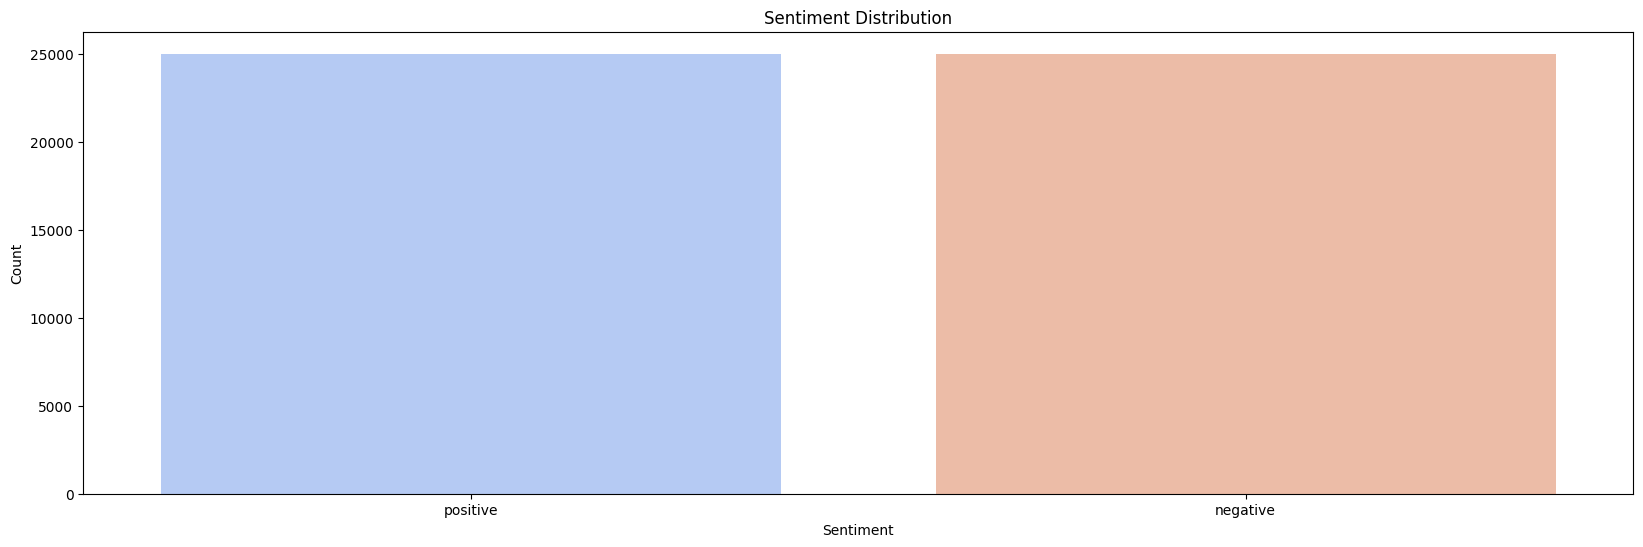

In [9]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

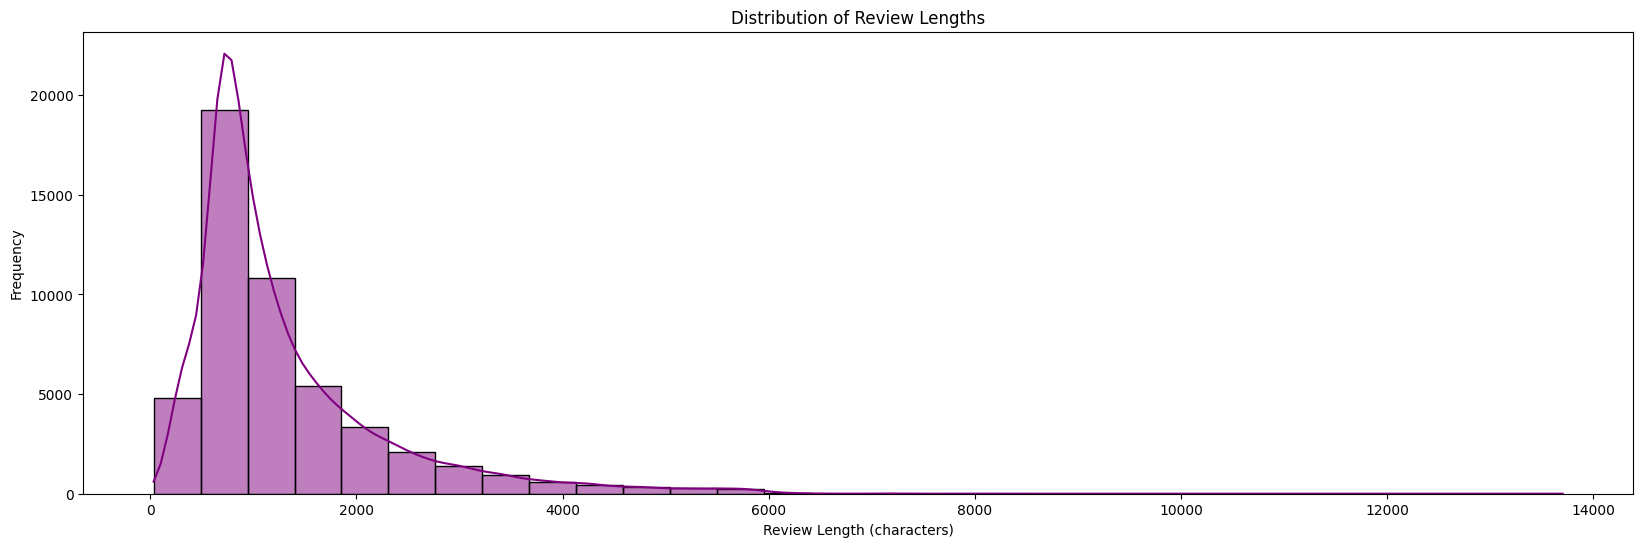

In [10]:
plt.figure(figsize=(20, 6))
sns.histplot(df['Review_Length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [11]:
sia = SentimentIntensityAnalyzer()

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess_and_analyze(review):
    tokens = word_tokenize(review.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    cleaned_review = ' '.join(filtered_tokens)
    sentiment_score = sia.polarity_scores(cleaned_review)
    return sentiment_score

In [14]:
df['Sentiment_Score'] = df['Review'].apply(preprocess_and_analyze)

In [15]:
df['Compound_Score'] = df['Sentiment_Score'].apply(lambda x: x['compound'])

In [16]:
df[['Review', 'Sentiment', 'Compound_Score']].head()

,Review,Sentiment,Compound_Score
0,One of the other reviewers has mentioned that ...,positive,-0.9927
1,A wonderful little production. <br /><br />The...,positive,0.9515
2,I thought this was a wonderful way to spend ti...,positive,0.9354
3,Basically there's a family where a little boy ...,negative,-0.8858
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9871


# Preprocess the Text Data

In [17]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [18]:
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
    return ' '.join(tokens)

In [19]:
df['Cleaned_Review'] = df['Review'].apply(preprocess_text)

# Sentiment Scoring

In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
df['Sentiment_Score'] = df['Cleaned_Review'].apply(lambda x: sia.polarity_scores(x))

In [22]:
df['Compound_Score'] = df['Sentiment_Score'].apply(lambda x: x['compound'])

# Sentiment Distribution by Compound Score

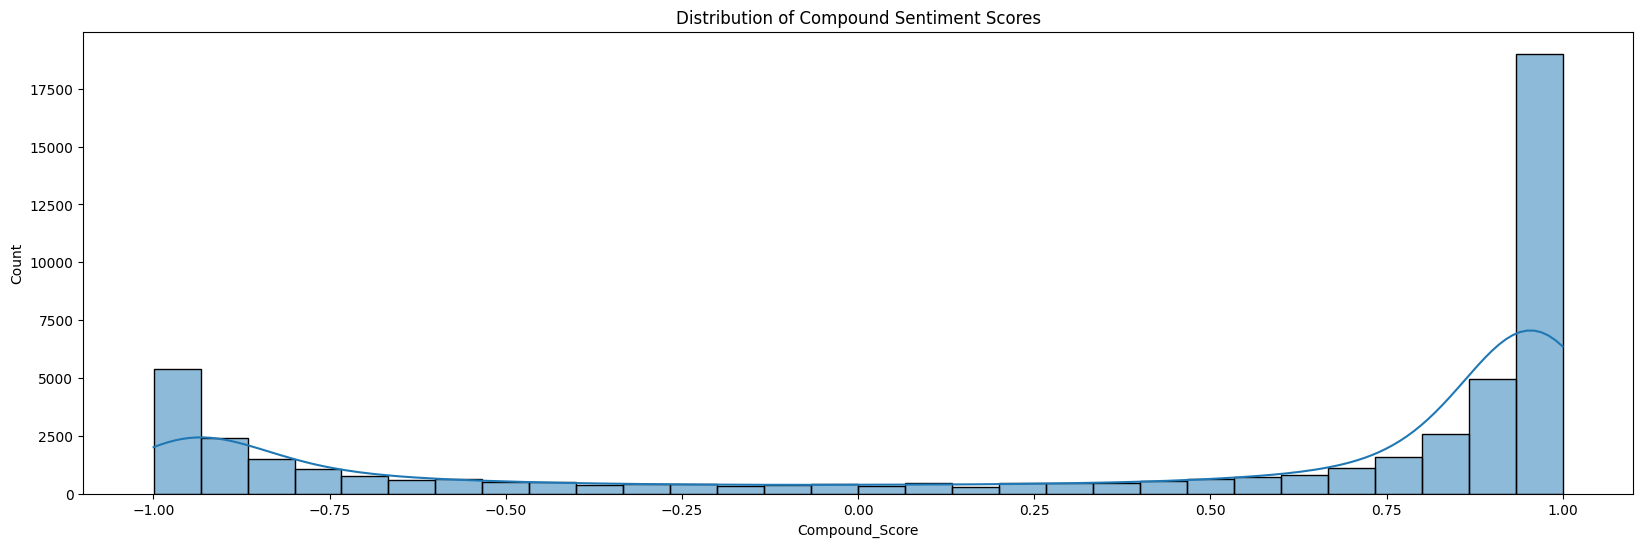

In [23]:
plt.figure(figsize=(20,6))
sns.histplot(df['Compound_Score'], bins=30, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.show()

# Sentiment by Review Length

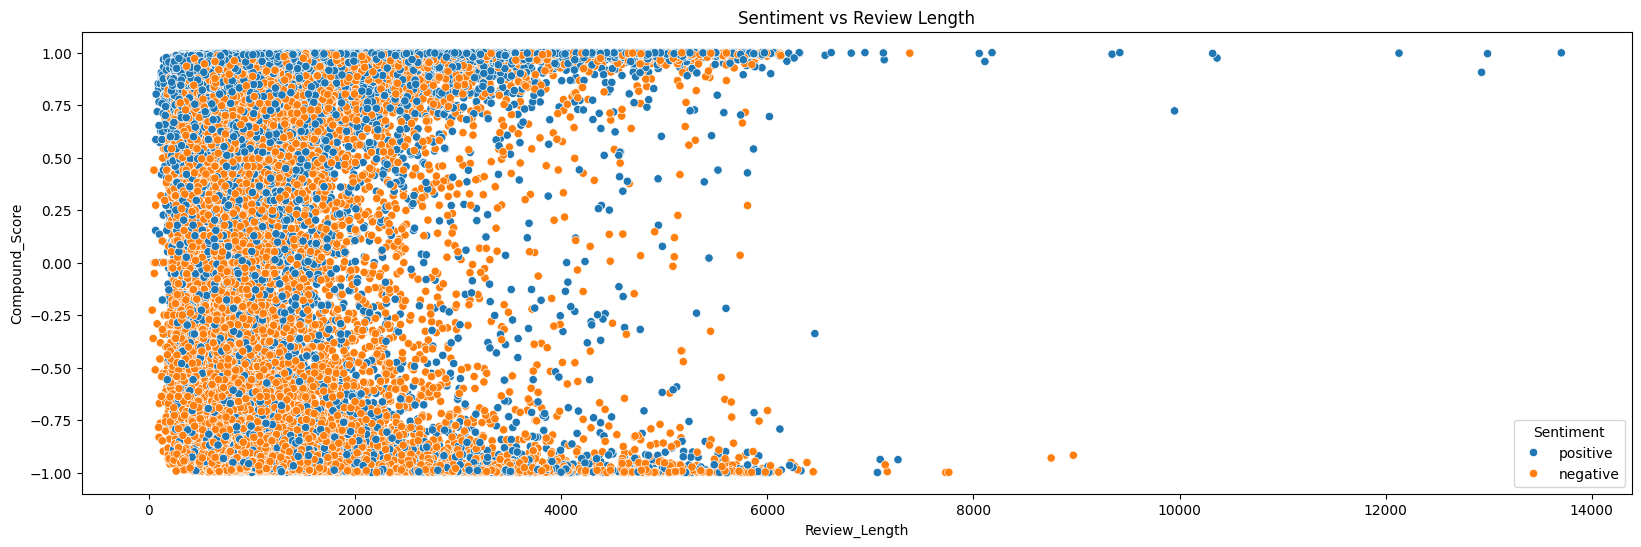

In [24]:
plt.figure(figsize=(20,6))
sns.scatterplot(x='Review_Length', y='Compound_Score', data=df, hue='Sentiment')
plt.title('Sentiment vs Review Length')
plt.show()

# Word Clouds for Positive and Negative Reviews

In [25]:
positive_reviews = df[df['Sentiment'] == 'positive']['Cleaned_Review']
negative_reviews = df[df['Sentiment'] == 'negative']['Cleaned_Review']

In [26]:
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(negative_reviews))

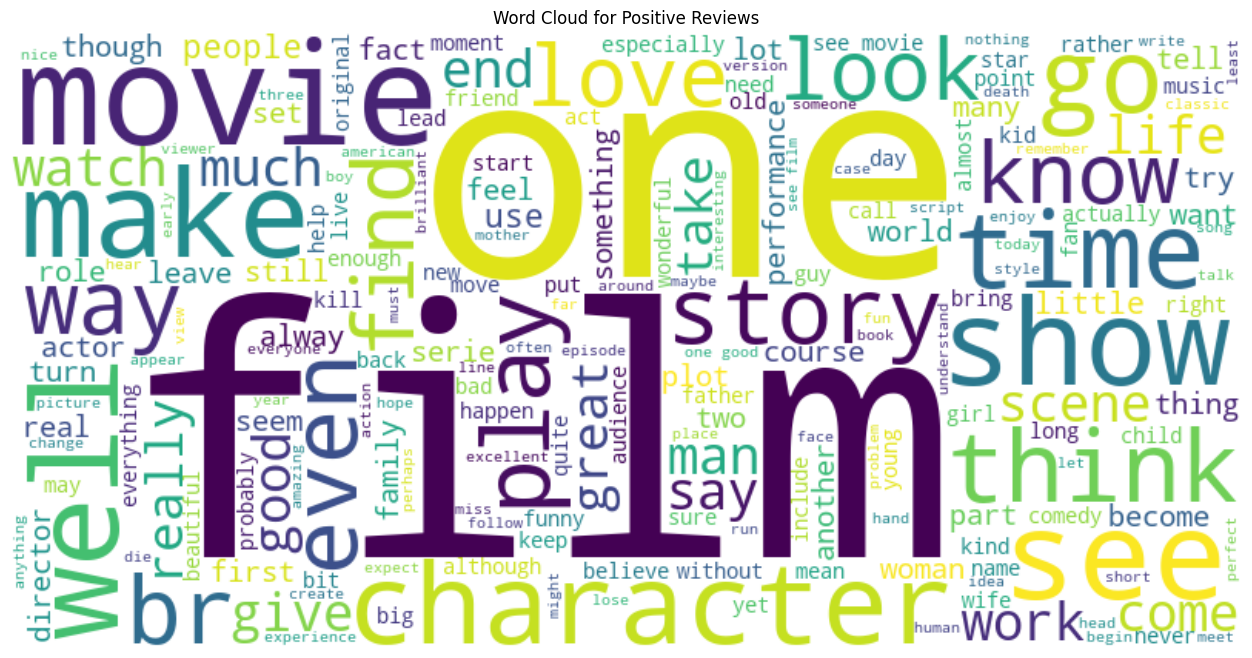

In [27]:
plt.figure(figsize=(20,8))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

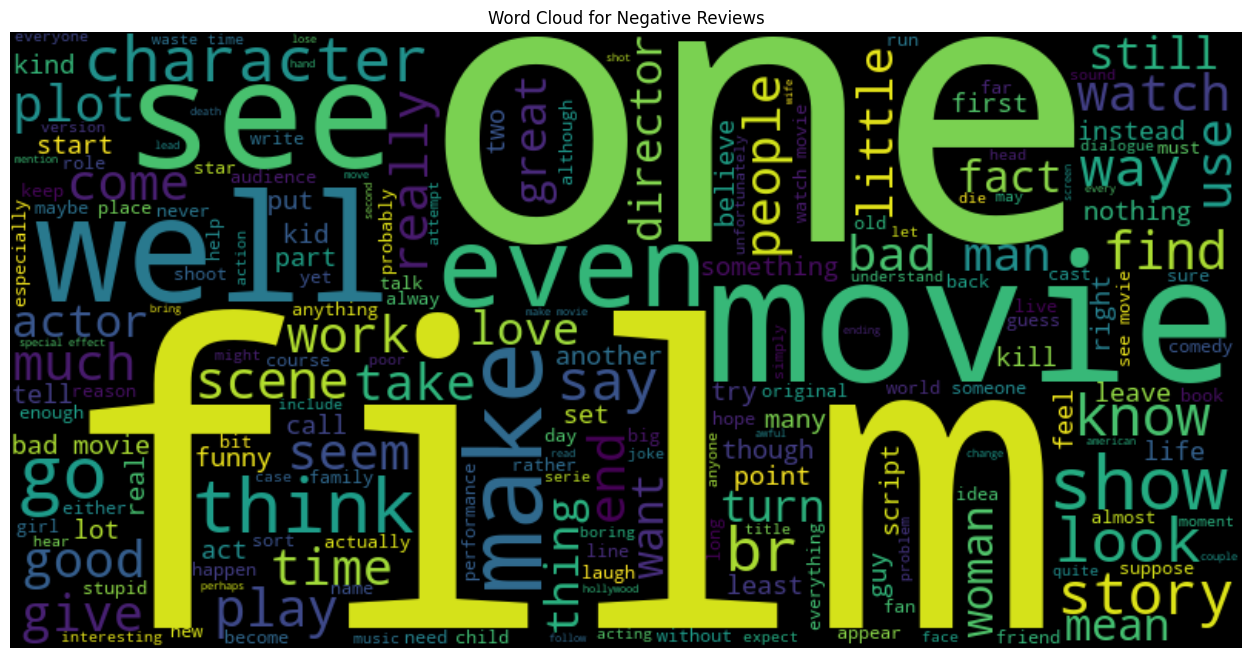

In [28]:
plt.figure(figsize=(20,8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Identify and Visualize Outliers

In [29]:
compound_threshold = 0.8
negative_threshold = -0.8
length_threshold_upper = df['Review_Length'].quantile(0.99)
length_threshold_lower = df['Review_Length'].quantile(0.01)

In [30]:
extreme_positive = df[df['Compound_Score'] >= compound_threshold]
extreme_negative = df[df['Compound_Score'] <= negative_threshold]

In [31]:
long_reviews = df[df['Review_Length'] >= length_threshold_upper]
short_reviews = df[df['Review_Length'] <= length_threshold_lower]

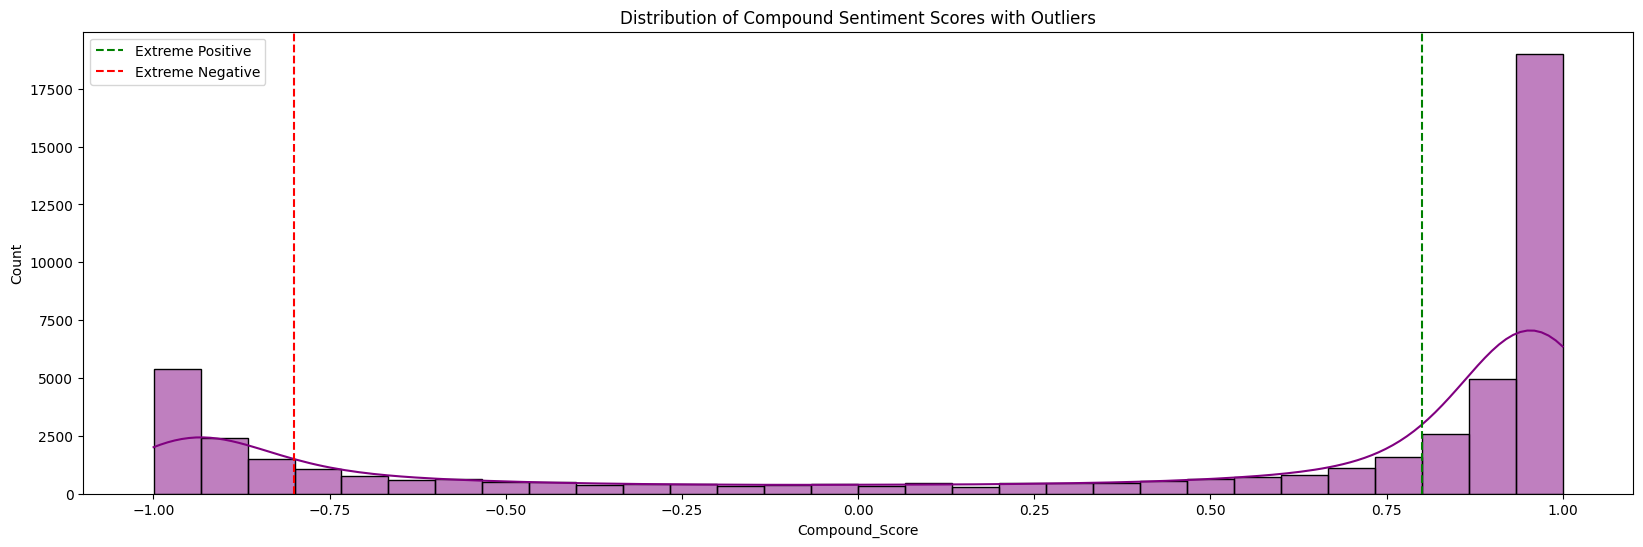

In [32]:
plt.figure(figsize=(20,6))
sns.histplot(df['Compound_Score'], bins=30, kde=True, color='purple')
plt.axvline(x=compound_threshold, color='green', linestyle='--', label='Extreme Positive')
plt.axvline(x=negative_threshold, color='red', linestyle='--', label='Extreme Negative')
plt.title('Distribution of Compound Sentiment Scores with Outliers')
plt.legend()
plt.show()

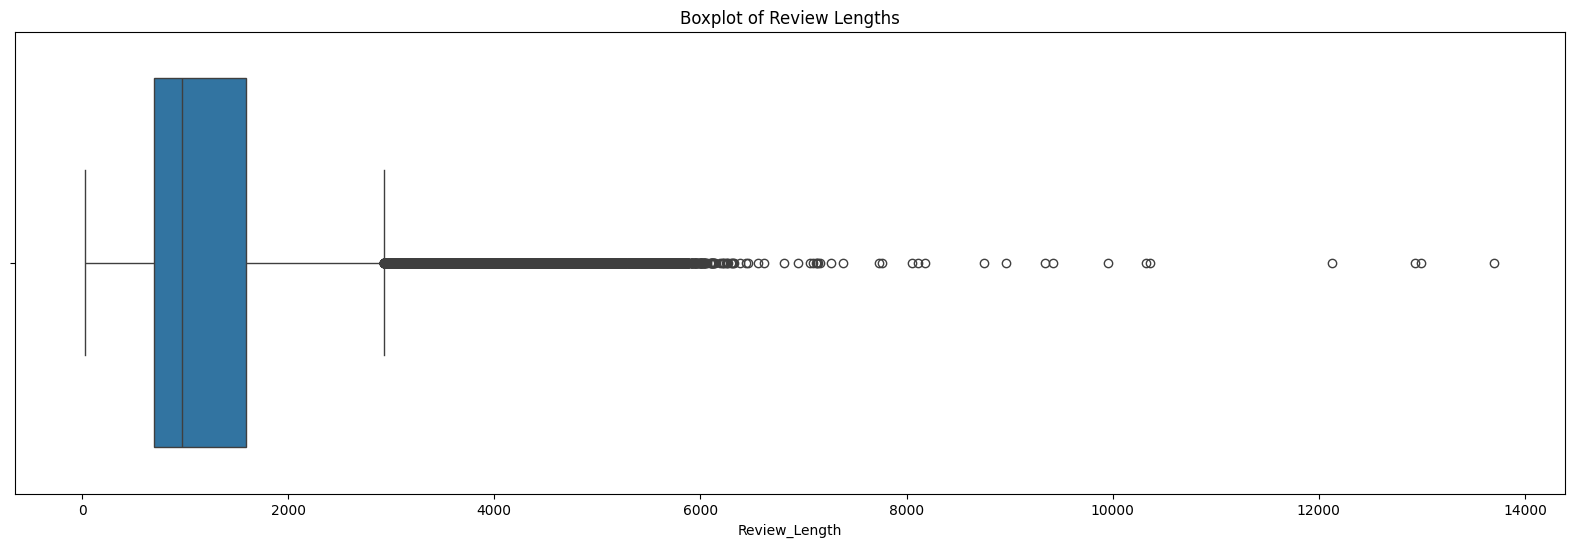

In [33]:
plt.figure(figsize=(20,6))
sns.boxplot(x=df['Review_Length'])
plt.title('Boxplot of Review Lengths')
plt.show()

# Aspect-Based Sentiment Analysis

In [34]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [35]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [36]:
df['Polarity'] = df['Cleaned_Review'].apply(get_polarity)
df['Subjectivity'] = df['Cleaned_Review'].apply(get_subjectivity)

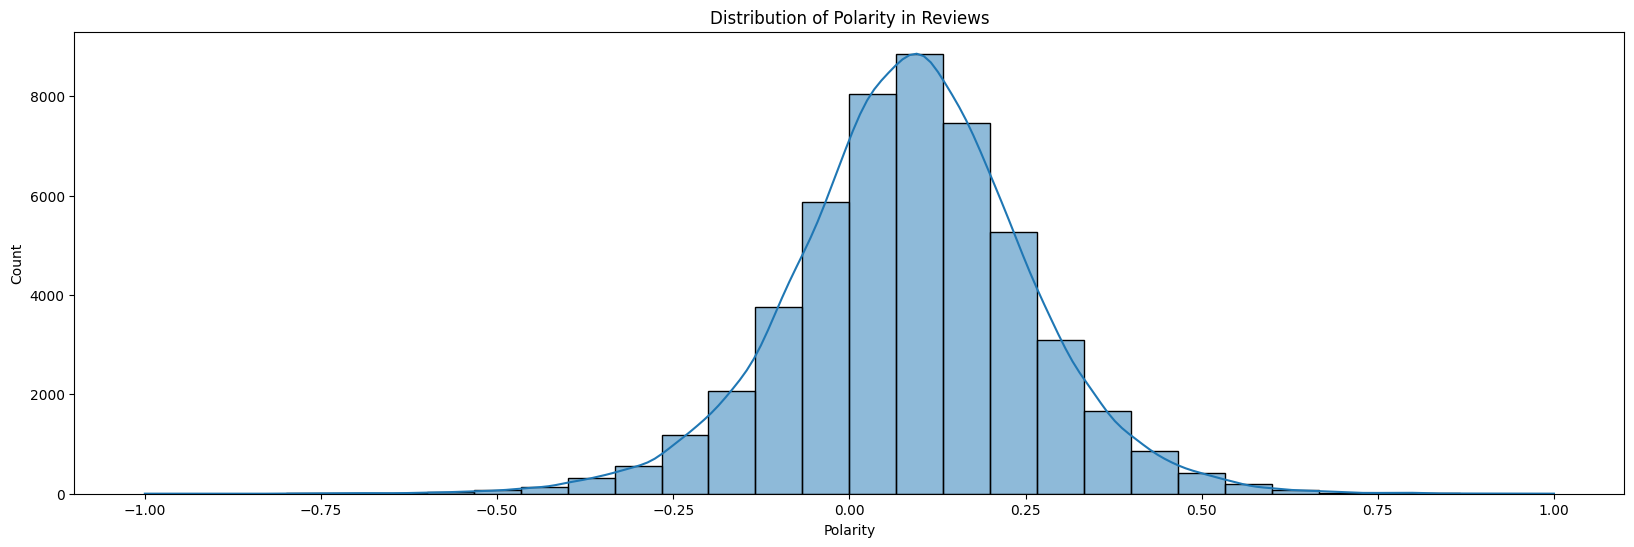

In [37]:
plt.figure(figsize=(20,6))
sns.histplot(df['Polarity'], bins=30, kde=True)
plt.title('Distribution of Polarity in Reviews')
plt.show()